# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [76]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [77]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [79]:
import torchvision.datasets as datasets

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

# train_dataset = datasets.CIFAR10(root=cifar10_path, train=True, download=False, transform=transform)
# test_dataset = datasets.CIFAR10(root=cifar10_path, train=False, download=False, transform=transform)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Посмотрим на изображения:

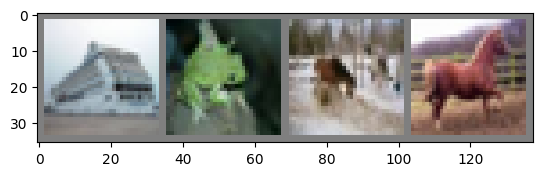

ship frog horse horse


In [80]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlockNet(nn.Module):
    def __init__(self):
        super(BasicBlockNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.shortcut = self.shortcut = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=1, stride=1, bias=False),
            )

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        x_original = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(x_original)
        out = self.relu(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [82]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [83]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [85]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [86]:
criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for i, (data, target) in enumerate(loader):
        images = data.to(device)
        labels = target.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_log.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)

        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        acc_log.append(accuracy)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for i, (data, target) in enumerate(train_loader):
        images = data.to(device)
        labels = target.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_log.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        acc_log.append(accuracy)

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [87]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4664042344694816, train acc: 47.79397362235571
 val loss: 1.2290639857028394, val acc: 56.861702127659576

Epoch 1
 train loss: 1.1498179613345283, train acc: 59.768379472447116
 val loss: 1.0557938649299297, val acc: 63.721187943262414

Epoch 2
 train loss: 1.0298872869019098, train acc: 63.89641551318883
 val loss: 1.0716811388096912, val acc: 62.1875

Epoch 3
 train loss: 0.9814608920862732, train acc: 65.74170801775921
 val loss: 0.9805775946759163, val acc: 66.27659574468085

Epoch 4
 train loss: 0.9404243821417828, train acc: 67.3882704361452
 val loss: 0.9722303111502465, val acc: 65.59397163120566

Epoch 5
 train loss: 0.9103754421038863, train acc: 68.41456646644032
 val loss: 0.9903613356833763, val acc: 65.85328014184397

Epoch 6
 train loss: 0.8889318604355975, train acc: 69.09196265343432
 val loss: 0.944731243113254, val acc: 67.677304964539

Epoch 7
 train loss: 0.8668019616298746, train acc: 69.87586510838338
 val loss: 0.9027401432077935, val acc

Посчитайте точность на тестовой выборке:

In [89]:
_, acc = test(net, test_loader)
acc

np.float64(70.1532643312102)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [90]:
n_epochs = 20

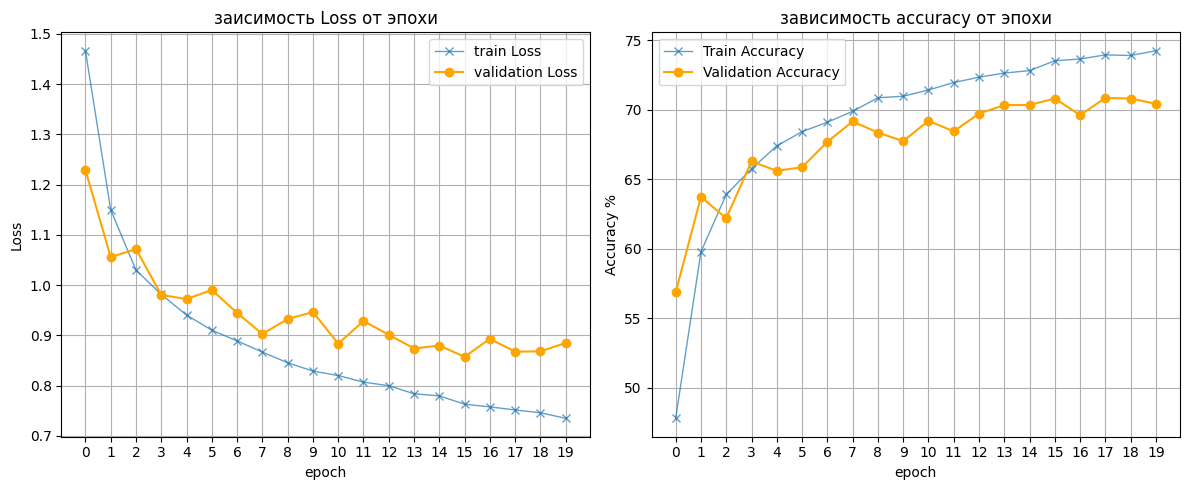

In [91]:
steps = np.arange(n_epochs)

train_epochs_batch_size = len(train_loss_log) // n_epochs
train_losses_by_epoch = np.array(train_loss_log).reshape(n_epochs, train_epochs_batch_size)
train_mean_loss_by_epoch = np.mean(train_losses_by_epoch, axis=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_mean_loss_by_epoch, 'x-', label='train Loss', alpha=0.7, linewidth=1)
plt.plot(steps, val_loss_log, 'o-', label='validation Loss', color='orange')
plt.xticks(steps, labels=steps) 
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('заисимость Loss от эпохи')
plt.legend()
plt.grid(True)

train_accs_by_epoch = np.array(train_acc_log).reshape(n_epochs, train_epochs_batch_size)
train_mean_accs_by_epoch = np.mean(train_accs_by_epoch, axis=1)

plt.subplot(1, 2, 2)
plt.plot(steps, train_mean_accs_by_epoch, 'x-', label='Train Accuracy', alpha=0.7, linewidth=1)
plt.plot(steps, val_acc_log, 'o-', label='Validation Accuracy', color='orange')
plt.xlabel('epoch')
plt.xticks(steps, labels=steps) 
plt.ylabel('Accuracy %')
plt.title('зависимость accuracy от эпохи')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [92]:
net2 = BasicBlockNet().to(device)
optimizer = optim.SGD(net2.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net2, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4939952452396343, train acc: 46.69259271350222
 val loss: 1.2822934074604766, val acc: 54.24645390070923

Epoch 1
 train loss: 1.1929159954435429, train acc: 58.28830961086445
 val loss: 1.2024597183186958, val acc: 56.715425531914896

Epoch 2
 train loss: 1.0550864294198574, train acc: 63.198615826586575
 val loss: 1.0726317129236587, val acc: 62.95877659574468

Epoch 3
 train loss: 0.9971437169821215, train acc: 65.11246408984069
 val loss: 1.0175995641566338, val acc: 64.25310283687944

Epoch 4
 train loss: 0.9560039794205312, train acc: 66.87859101593106
 val loss: 1.0164540125968609, val acc: 65.44769503546098

Epoch 5
 train loss: 0.924420029415291, train acc: 68.11953186210499
 val loss: 0.9975694836454189, val acc: 66.50265957446808

Epoch 6
 train loss: 0.905340540779574, train acc: 68.40885348655002
 val loss: 0.9514704366947743, val acc: 66.87056737588652

Epoch 7
 train loss: 0.8892872700743527, train acc: 68.92587816662314
 val loss: 0.89923559275079

Посчитайте точность на тестовой выборке:

In [93]:
_, acc = test(net2, test_loader)
acc

np.float64(71.53662420382166)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net3 = BasicBlockNet().to(device)
optimizer_const = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

tr_loss_log_const, tr_acc_log_const, val_loss_log_const, val_acc_log_const = train(
    net3, optimizer_const, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.818115135215536, train acc: 36.55735831809872
 val loss: 1.601160719546866, val acc: 43.590425531914896

Epoch 1
 train loss: 1.5299816735265896, train acc: 46.41959388874379
 val loss: 1.4465747660778938, val acc: 49.213209219858165

Epoch 2
 train loss: 1.4205867605627782, train acc: 50.21178832593366
 val loss: 1.3659959808309028, val acc: 52.02127659574468

Epoch 3
 train loss: 1.3499306847887893, train acc: 52.73121245756072
 val loss: 1.3502113382867043, val acc: 52.77260638297872

Epoch 4
 train loss: 1.29561402135183, train acc: 54.66260773047793
 val loss: 1.2816650253661135, val acc: 54.663120567375884

Epoch 5
 train loss: 1.2512209763038746, train acc: 56.282237529381035
 val loss: 1.224294559245414, val acc: 57.42686170212766

Epoch 6
 train loss: 1.2107332682260865, train acc: 57.83616805954557
 val loss: 1.1917950097550738, val acc: 58.410904255319146

Epoch 7
 train loss: 1.1706710549333632, train acc: 59.271758291982245
 val loss: 1.1783079408584

In [97]:
_, acc = test(net3, test_loader)
acc

np.float64(66.25199044585987)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

можно изменять LR экспоненциально по формуле lr = lr * gamma^epoch

In [98]:
net311 = BasicBlockNet().to(device)
optimizer = optim.SGD(net311.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log_const, tr_acc_log_const, val_loss_log_const, val_acc_log_const = train(
    net311, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.473305767371406, train acc: 47.803767302167664
 val loss: 1.2281980085880198, val acc: 57.276152482269495

Epoch 1
 train loss: 1.081686168200791, train acc: 62.3412607730478
 val loss: 1.0550585112673172, val acc: 62.90336879432625

Epoch 2
 train loss: 1.0225743045536648, train acc: 64.35590232436668
 val loss: 1.0350688454952646, val acc: 63.74778368794327

Epoch 3
 train loss: 1.015058350846362, train acc: 64.5611615304257
 val loss: 1.0339065901776578, val acc: 63.97828014184397

Epoch 4
 train loss: 1.0123212531454167, train acc: 64.63094149908592
 val loss: 1.0342901057385383, val acc: 63.95168439716311

Epoch 5
 train loss: 1.013785129927194, train acc: 64.58278924001044
 val loss: 1.0342529895457815, val acc: 63.976063829787236

Epoch 6
 train loss: 1.014385539391359, train acc: 64.71418777748758
 val loss: 1.0339795825329232, val acc: 64.00265957446808

Epoch 7
 train loss: 1.0132518954425234, train acc: 64.64195938887438
 val loss: 1.0335368775306863, 

In [99]:
_, acc = test(net311, test_loader)
acc

np.float64(63.7937898089172)

можно изменять lr по косинусу от 1 до 0

In [100]:
net312 = BasicBlockNet().to(device)
optimizer = optim.SGD(net312.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=32)
tr_loss_log_const, tr_acc_log_const, val_loss_log_const, val_acc_log_const = train(
    net312, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5274851136931118, train acc: 45.3112757900235
 val loss: 1.3638359379261098, val acc: 50.964095744680854

Epoch 1
 train loss: 1.1978853921349786, train acc: 58.078561634891614
 val loss: 1.1708789011265368, val acc: 59.22872340425532

Epoch 2
 train loss: 1.074434048188016, train acc: 62.51999542961609
 val loss: 1.0431135210585087, val acc: 63.902925531914896

Epoch 3
 train loss: 1.0171343538181437, train acc: 64.87251893444763
 val loss: 1.0041173295771821, val acc: 65.06648936170212

Epoch 4
 train loss: 0.9700315754853829, train acc: 66.26199725776965
 val loss: 1.0307333872673359, val acc: 64.34175531914893

Epoch 5
 train loss: 0.9330293197300578, train acc: 67.61801384173414
 val loss: 0.9713617025537694, val acc: 66.43395390070921

Epoch 6
 train loss: 0.9004713453257106, train acc: 68.86385152781406
 val loss: 0.9529547516335832, val acc: 67.2872340425532

Epoch 7
 train loss: 0.8767060623308423, train acc: 69.5987855837033
 val loss: 0.981975970116067

In [101]:
_, acc = test(net312, test_loader)
acc

np.float64(71.36743630573248)

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

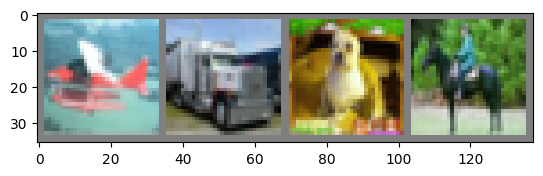

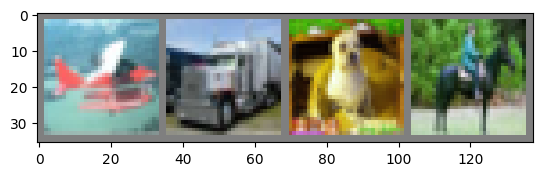

In [73]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net4 = BasicBlockNet().to(device)
optimizer = optim.SGD(net4.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net4, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4919332210280996, train acc: 47.13330830504049
 val loss: 1.2597771177900599, val acc: 55.538563829787236

Epoch 1
 train loss: 1.1922029528147124, train acc: 58.537640376077306
 val loss: 1.1439718857724617, val acc: 59.55895390070923

Epoch 2
 train loss: 1.0723702593738897, train acc: 62.75014690519718
 val loss: 1.12110540537124, val acc: 60.536347517730505

Epoch 3
 train loss: 1.0259143304781242, train acc: 64.33345847479761
 val loss: 0.9662726326191678, val acc: 66.57358156028369

Epoch 4
 train loss: 0.9779139902081743, train acc: 66.08203839122486
 val loss: 0.9733088305655946, val acc: 66.06161347517731

Epoch 5
 train loss: 0.9515181042158626, train acc: 67.02223165317315
 val loss: 0.980597675100286, val acc: 67.14982269503547

Epoch 6
 train loss: 0.9179749505175533, train acc: 68.2513384695743
 val loss: 0.9487684485760141, val acc: 67.50443262411348

Epoch 7
 train loss: 0.9045958949399386, train acc: 68.64390180203709
 val loss: 0.893962634877955

Посчитайте точность на тестовой выборке:

In [75]:
_, acc = test(net3, test_loader)
acc

np.float64(71.94466560509554)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

В библиотеке представлены разные трансфрмации, например различные повороты изображений с какой-то вероятностью, изменение яркости, контрастности. также можно вырезать определенную область область из картинки и др.

In [ ]:
# <your code here>

Your answers here:

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
# <your code here>